In [3]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt

utilspath=os.path.join("..","util")
sys.path = [utilspath]+sys.path
import myLandlabTools as tools
%matplotlib inline

C:\Users\wher.KENTRONNET\AppData\Local\Continuum\Anaconda3\envs\landlab\lib\site-packages\ipykernel_launcher.py:5: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "C:\Users\wher.KENTRONNET\AppData\Local\Continuum\Anaconda3\envs\landlab\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\wher.KENTRONNET\AppData\Local\Continuum\Anaconda3\envs\landlab\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\wher.KENTRONNET\AppData\Local\Continuum\Anaconda3\envs\landlab\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\wher.KENTRONNET\AppData\Local\Continuum\Anaconda3\envs\landlab\lib\si

In [4]:

storm = 'intense1'

theFolder = 'valleyTopoIntense1'

# dataframe with all files in the folder
df = tools.filesToDf(theFolder)
if df.shape[0]  < 1:
    print('dataframe has zero length, check theFolder={}'.format(theFolder))
    exit()
# print(df.head())

dfSummary = pd.DataFrame()

# run through all files and create summary dataframe
for filename in df['filename']:

    line = []
    
    Slope,ManningN,HCond,InfilDepth = tools.decodeLLFilename(filename)
    gradient = Slope.strip('valley')
    slope = int(gradient)
    
    hydrograph_time, discharge_at_outlet, h, d = tools.readLLData(filename)

    # info from hydrograph
    maxD = max(np.abs(discharge_at_outlet))
    
    # get index where this max is
    absD = np.abs(discharge_at_outlet)
    indexMax = absD.argmax(axis=0)
    timeMaxD = hydrograph_time[indexMax]

    sumD = sum(np.abs(discharge_at_outlet)[1:]*np.diff(np.array(hydrograph_time))*3600.)

    dfSummary = dfSummary.append({'slope':slope,
                                    'ManningN':ManningN,
                                    'HCond':HCond,
                                    'InfilDepth':InfilDepth,
                                    'maxDischarge':maxD,
                                    'timeOfMaxDischarge':timeMaxD,
                                    'sumDischarge':sumD}, ignore_index=True)
# remove high conductivity value, it confuses the interpretation
dfSummary = dfSummary[dfSummary['HCond'] != 1.6e-05]    


In [5]:
slopeU = dfSummary['slope'].unique()
ManningNU = dfSummary['ManningN'].unique()
InfilDepthU = dfSummary['InfilDepth'].unique()
HCondU = dfSummary['HCond'].unique()
slopeU.sort()
ManningNU.sort()
InfilDepthU.sort()
HCondU.sort()

print('HCond:\n{}'.format(HCondU))
print('InfilDepth:\n{}'.format(InfilDepthU))
print('ManningN:\n{}'.format(ManningNU))
print('slope:\n{}'.format(slopeU))
print(dfSummary.columns)

HCond:
[  1.70000000e-07   2.70000000e-07   3.30000000e-07   5.50000000e-07
   7.20000000e-07   8.30000000e-07   1.80000000e-06   3.60000000e-06
   6.10000000e-06]
InfilDepth:
[ 0.1]
ManningN:
[ 0.03  0.04  0.05  0.06  0.07]
slope:
[  2.   5.  10.  15.  20.  25.]
Index(['HCond', 'InfilDepth', 'ManningN', 'maxDischarge', 'slope',
       'sumDischarge', 'timeOfMaxDischarge'],
      dtype='object')


In [6]:
def plotTriple(df,xValue,yValue,filt1,filt2,xlabel,ylabel,plotAll=False,cmap='hot'):
    """Plot three heat maps for selected x and y values, as filtered
    
    df is the complete data set in dataframe format
    xValue is the df column to be used along x axis
    yValue is the df column to be used along y axis
    filt1 and filt2 are the filters to filter by df columns, 
        the format is columnName=index
    """

    pValues = ['maxDischarge','sumDischarge']
    barlabel = ['Maximum Discharge (m$^3$/s)','Cumulative Discharge (m$^3$)']
    ncols = 2
    if plotAll:
        pValues.append('timeOfMaxDischarge')
        barlabel.append('Time (h)')
        ncols = 3
    
    # build filter requiremens from filter strings
    filt1Col,filt1Val = filt1.split('|')
    filt2Col,filt2Val = filt2.split('|')
    # get list of unique values, sorted
#     print(df)
    lstf1 = df[filt1Col].unique()
    lstf1.sort()
    lstf2 = df[filt2Col].unique()
    lstf2.sort()
#     print(lstf1)
    
    # filter the dataframe
    dff = dfSummary[((dfSummary[filt1Col]==lstf1[int(filt1Val)]) & \
                     (dfSummary[filt2Col]==lstf2[int(filt2Val)]))]
#     dff = df.drop([filt1Col,filt2Col],axis=1)
    fig, lstAx = plt.subplots(nrows=1,ncols=ncols,figsize=(ncols*7, 5))

    for i,pValue in enumerate(pValues):

        # extract data in pivot table
        table = dff.pivot(values=pValue, index=yValue, columns=xValue)

        # plot cmaps here: https://matplotlib.org/examples/color/colormaps_reference.html
#         heatmap = lstAx[i].imshow(table, cmap='hot', interpolation='nearest')
#         heatmap = lstAx[i].imshow(table, cmap='jet', interpolation='nearest')
#         heatmap = lstAx[i].imshow(table, cmap='terrain', interpolation='nearest')
#         heatmap = lstAx[i].imshow(table, cmap='hsv', interpolation='nearest')
#         heatmap = lstAx[i].imshow(table, cmap='cool', interpolation='nearest')
#         heatmap = lstAx[i].imshow(table, cmap='copper', interpolation='nearest')
        heatmap = lstAx[i].imshow(table, cmap=cmap, interpolation='nearest')
        
        # set current subplot as current axes
        plt.sca(lstAx[i])
        # build x and y tick marks
        x = dff[xValue].unique()
        x.sort()
        xi = [i for i in range(0, len(x))]
        plt.xticks(xi, x)
        y = dff[yValue].unique() 
        y.sort()
        yi = [i for i in range(0, len(y))]
        plt.yticks(yi, y)
        # colour bar and labels
        cbar = plt.colorbar(heatmap)
        cbar.set_label(barlabel[i])
#         plt.title(pValue)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        
    filename = '{}-vs-{}-for-{}={}-{}={}.png'.format(xValue,yValue,filt1Col,lstf1[int(filt1Val)],filt2Col,lstf2[int(filt2Val)])
    print(filename)
    plt.savefig(filename,dpi=300)
    plt.show()


ManningN-vs-HCond-for-slope=25.0-InfilDepth=0.1.png


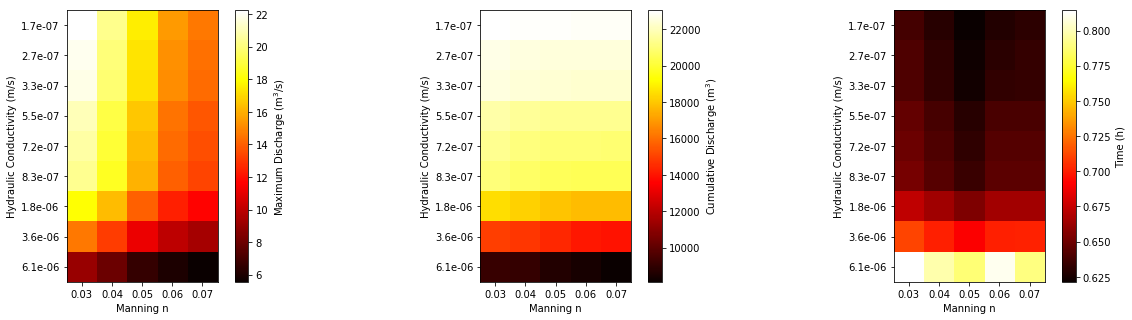

In [30]:
plotTriple(dfSummary,xValue='ManningN',yValue='HCond',
           xlabel='Manning n',ylabel='Hydraulic Conductivity (m/s)',
           filt1='slope|5',filt2='InfilDepth|0',plotAll=True)

ManningN-vs-slope-for-HCond=6.1e-06-InfilDepth=0.1.png


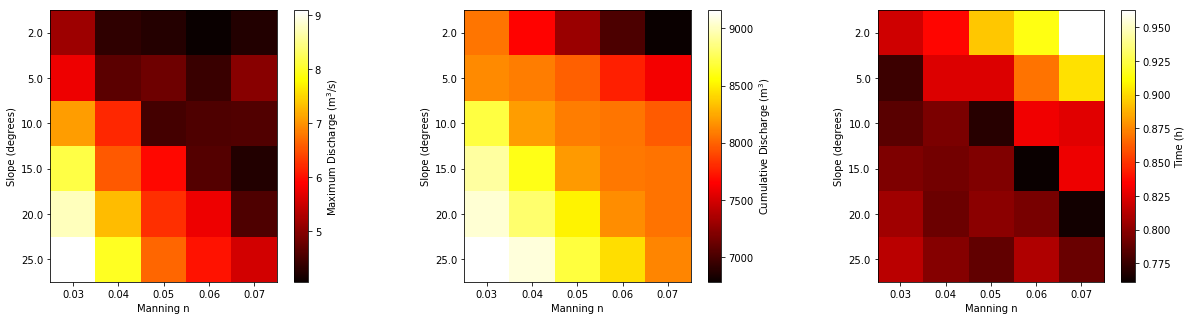

In [24]:

plotTriple(dfSummary,xValue='ManningN',yValue='slope',
                      xlabel='Manning n',ylabel='Slope (degrees)',
                        filt1='HCond|8',filt2='InfilDepth|0',plotAll=True)


slope-vs-HCond-for-ManningN=0.07-InfilDepth=0.1.png


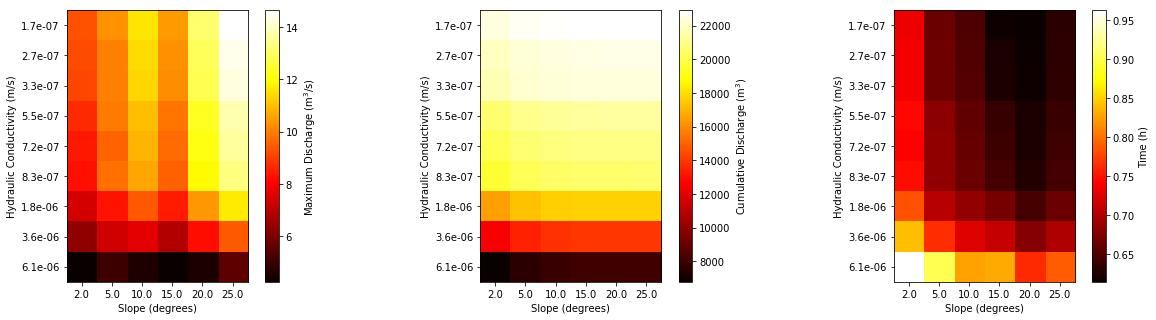

In [13]:
plotTriple(dfSummary,xValue='slope',yValue='HCond',
                      xlabel='Slope (degrees)',ylabel='Hydraulic Conductivity (m/s)',
                    filt1='ManningN|4',filt2='InfilDepth|0',plotAll=True)
